In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2019-05-26 17:05:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.3’

adult.data.3        100%[===================>]   3.79M  1.36MB/s    in 2.8s    

2019-05-26 17:05:58 (1.36 MB/s) - ‘adult.data.3’ saved [3974305/3974305]



## Imports

In [2]:
import pandas as pd
import numpy as np

## Read in our data

In [3]:
column_names = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

I am using [Pandas](https://pandas.pydata.org/) to read an manipulate the data. It makes it easy to work with tabular data and is the default data tool for most data-science work.

The dataformat is a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [4]:
df = pd.read_csv('adult.data', names=column_names)

In [5]:
# quick look at the top few rows
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
# and get a sense of the size of the dataframe
df.shape

(32561, 15)

Pandas can access columns by their string names. In this case we want to turn the `Income` column into a target variable (the thing we are trying to predict). Everything matching ` >50K` is turned into a `True` and everything else is a `False`. This 'binary target' is the bread-and-butter of classification.

As a technical note, when you use a string to grab a column from a pandas dataframe, it returns a [Series](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.html). I use the `.values` attribute to get a numpy array and then turn the `True` and `False` values into `1` and `0` values by [casting](https://www.w3schools.com/python/python_casting.asp) the values to `int`.

In [7]:
y = (df['Income'] == ' >50K').values.astype(int)

In [8]:
use_columns = ['Age', 'HoursPerWeek']
X = df[use_columns]

We are almost ready to fit our first model, but before we do, we need to create training and testing sets. Why is it necessary to split our data? We want to be sure we are not [overfitting](https://elitedatascience.com/overfitting-in-machine-learning) ([wiki](https://en.wikipedia.org/wiki/Overfitting)).

If we had a model that fit the training perfectly, it may not generalize well to new data.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# splits both X and y into train and testing data - I am using the `random_state` argument to reproduce the same results
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=432345)

## Logistic Regression

Let's start with one of the simplest models: [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). By default, this model adds "[regularization](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization)". In this case an "L2" regularization. In practical terms this makes a model that 1) tries to fit the data as well as possible while 2) keep the coefficients as small as possible. This second part helps to avoid overfitting by not letting the model fit too closely to our training data.

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
# initialize the model by calling the class `LogisticRegression`
model = LogisticRegression()

In [13]:
# now that we have our model we can call the `fit` method
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
# get the predicted classes (0 or 1)
model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
# get the odds (probability) of each class this is an Nx2 array where the first column contains the probability of the first class
model.predict_proba(X_train)

array([[0.6119385 , 0.3880615 ],
       [0.51311941, 0.48688059],
       [0.91545097, 0.08454903],
       ...,
       [0.93442776, 0.06557224],
       [0.84230077, 0.15769923],
       [0.81645598, 0.18354402]])

### Testing our model

We want to see how good our model is at fitting the data. This is a classification model, so one sensible way of seeing how good our model would be would be to look at the "accuracy", that is, how often does something that we say should happen actually happen and how often does something we say shouldn't happen not happen (see: https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers for more). 

Accuracy can be a misleading metric based on the base rate of the event. If the event usually happens 99% of the time, a classifier could get 99% accuracy by just guessing that event all the time. 

A better metric would balance both the true positive rate (how often the thing we predicted happened) and the false positive rate (how often the thing we predicted didn't happen). A popular metric for that is the "area under the receiving operator curve" or [AUROC](http://fastml.com/what-you-wanted-to-know-about-auc/) (sometimes just called AUC).

This metric goes from 0.5 to 1.0, where 0.5 is a random classifier and 1.0 is a perfect classifier.

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

In [17]:
# we are going to get the false positive rates and true positive rates to plot
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
# and the total area under the curve
auroc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'AUROC: 0.73')

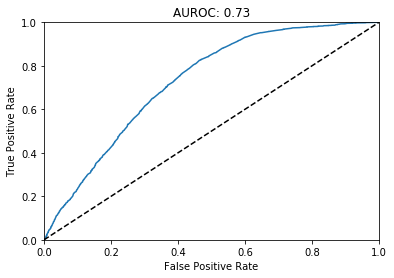

In [19]:
# plot the ROC
fig, axis = plt.subplots()
axis.plot(fpr, tpr)
axis.set_xlabel('False Positive Rate')
axis.set_ylabel('True Positive Rate')

axis.plot([0, 1], [0, 1], color='black', linestyle='--')
axis.set_xlim([0, 1])
axis.set_ylim([0, 1])
axis.set_title(f'AUROC: {auroc:.2f}')

We can look at the coefficients of our model by examining the `coef_` attribute.

In [20]:
model.coef_

array([[0.04314066, 0.04641807]])

Since we will need to make this plot often, let's make it into a function.

In [21]:
def make_auc_plot(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Make a beautiful plot of the receiver operating characteristic curve
    
    Parameters
    ----------
    y_true: ndarray
        An array of the true labels (1s for True, 0s for False)
    y_pred: ndarray
        An array of the predictions (between 0 and 1)
    
    
    Side Effects
    ------------
    Produces a matplotlib figure
    """
  
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auroc = roc_auc_score(y_true, y_pred)
  
    fig, axis = plt.subplots()
    axis.plot(fpr, tpr)
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')

    axis.plot([0, 1], [0, 1], color='black', linestyle='--')
    axis.set_xlim([0, 1])
    axis.set_ylim([0, 1])
    axis.set_title(f'AUROC: {auroc:.2f}')  # using formating codes here https://pyformat.info/

# New model types

## Decision Trees

These flexible models can fit complicated functions with interactions between features and ability to handle different data. They tend to not fit that well and to overfit.
[Wiki](https://en.wikipedia.org/wiki/Decision_tree) [SKLearn Docs](https://scikit-learn.org/stable/modules/tree.html)

An example of a decision tree:

![Example Tree](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dtc_0021.png)

In [22]:
# again we will import a new model type from sklearn
from sklearn.tree import DecisionTreeClassifier

In [23]:
# we initialize the model using the same structure as before
tree_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)

In [24]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

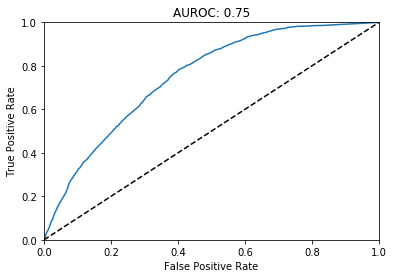

In [25]:
y_pred = tree_model.predict_proba(X_test)[:, 1]
make_auc_plot(y_test, y_pred)

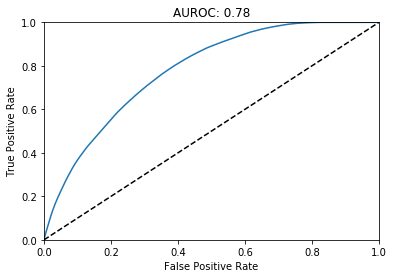

In [26]:
y_pred = tree_model.predict_proba(X_train)[:, 1]
make_auc_plot(y_train, y_pred)

## Add Another Feature

Let's add a new feature `MaritalStatus` to our model. We run into a problem in that Marital Status is a feature of different strings. We need to find a way to 'encode' this value into a numeric value.

The method we will use here is called 'dummy encoding' or 'one-hot' encoding. We will create a new feature for each string in the old feature and then give that row a 1 for the new feature if it takes that value (e.g. we would create a 'Divorced' feature and then place a 1 in each row that had an `MaritalStatus` value 'Divorced'). Bonus: there are some 'fancier' ways that one could use to encode categorical variables for instance in this [blog post](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159).

In [27]:
# We could also do this directly in sklearn:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
marital_status_dummies = pd.get_dummies(df['MaritalStatus'])

In [28]:
marital_status_dummies.head()

,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


In [29]:
use_columns = ['Age', 'HoursPerWeek', 'MaritalStatus']

In [30]:
X = pd.get_dummies(df[use_columns])

In [31]:
X.head()

,Age,HoursPerWeek,MaritalStatus_ Divorced,MaritalStatus_ Married-AF-spouse,MaritalStatus_ Married-civ-spouse,MaritalStatus_ Married-spouse-absent,MaritalStatus_ Never-married,MaritalStatus_ Separated,MaritalStatus_ Widowed
0,39,40,0,0,0,0,1,0,0
1,50,13,0,0,1,0,0,0,0
2,38,40,1,0,0,0,0,0,0
3,53,40,0,0,1,0,0,0,0
4,28,40,0,0,1,0,0,0,0


In [32]:
# now that we have new columns we need to redo our train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3523523)

In [33]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

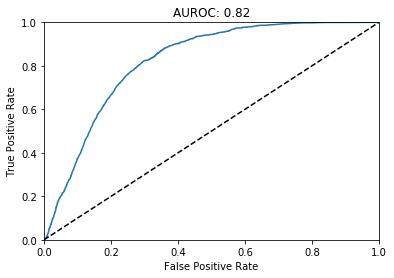

In [34]:
y_pred = model.predict_proba(X_test)[:, 1]
make_auc_plot(y_test, y_pred)

Sometimes there are lots of categories. For instance the `NativeCountry` feature has 42 unique values. We want to add this information to our model, but adding 42 features seems like a lot for our simple model. Let's add just an 'indicator' if the person came from the USA.

In [35]:
len(np.unique(df['NativeCountry']))

42

In [36]:
# we can add a new column like we would add an entry to a dictionary
X['from_USA'] = (df['NativeCountry'] == ' United-States').astype(int)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4535234)

In [38]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

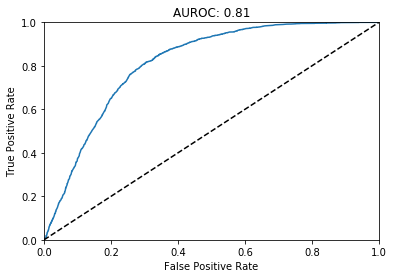

In [39]:
y_pred = model.predict_proba(X_test)[:, 1]
make_auc_plot(y_test, y_pred)

In [40]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

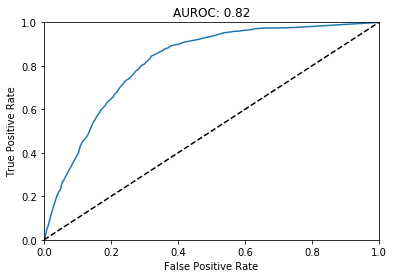

In [41]:
y_pred = tree_model.predict_proba(X_test)[:, 1]
make_auc_plot(y_test, y_pred)

## Hyperparameter Tuning

The last step on our journey is to conduct some hyperparameter tuning. We have several parameters that we can set in our Decision Tree, and it is not always obvious what we should set them to. We can use a grid search to find the best model after we change many different parameters.

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
# initialize our model with the default parameters
tree_model = DecisionTreeClassifier()

In [44]:
# set up a dictionary with lists for the different parameter values
param_grid = {'min_samples_leaf': [1, 2, 10, 20, 100], 'min_impurity_decrease': [0.0, 0.1, 0.2]}
# initialize our grid searcher
grid_searcher = GridSearchCV(tree_model, param_grid)

In [45]:
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 2, 10, 20, 100], 'min_impurity_decrease': [0.0, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
# get our best model
tree_model = grid_searcher.best_estimator_

In [47]:
tree_model.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

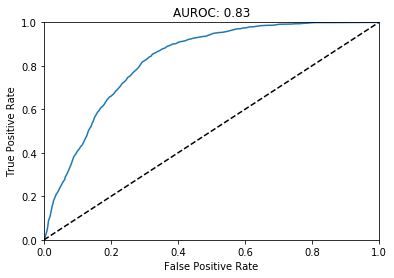

In [48]:
y_pred = tree_model.predict_proba(X_test)[:, 1]
make_auc_plot(y_test, y_pred)

# Group time!

Some ideas:

1. Explore more feature engineering and more features
2. Explore other model types:
    - ensemble methods: either gradient boosted classifiers or random forests
    - GAMs (https://github.com/dswah/pyGAM)
    - other classifiers (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
3. Explore the data (or model) using visualizations
4. Do so clustering analysis of the data
5. Mix and match from above


## A note on making plots

If there is one thing I have learned in Astro grad school it is how to make good plots, things like: labeling axes, having clear style, and choosing the right plot type. These small things will make a big difference when presenting your work to a wide array of audiences.

So you want to make some plots...

What type of plot do you want to make? If you need inspiration or want to see different options you can check out the sites below.

https://www.data-to-viz.com/

https://datavizcatalogue.com/index.html

http://datavizproject.com/

And see some examples of common plots made in different python libraries.

http://pythonplot.com/

In [49]:
import xgboost
from xgboost import XGBClassifier

In [50]:
use_cols = [
    'Age', 'WorkClass', 'EducationNum', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Gender',
 'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'NativeCountry'
]
X = pd.get_dummies(df[use_cols])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=432345)

In [52]:
model = XGBClassifier(n_estimators=250, max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
y_pred = model.predict_proba(X_test)[:, 1]

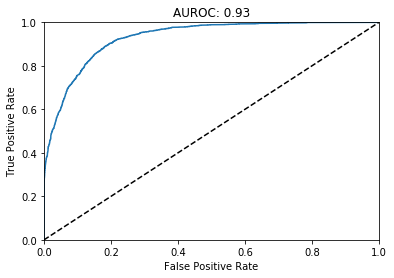

In [54]:
make_auc_plot(y_test, y_pred)